**Getting Data**

In previous notebook we downloaded photos and save them on google drive 

In [1]:
"""libraries we use"""
!sudo apt-get install unzip
from google.colab import drive
from google.colab import files
import csv 
drive.mount('/content/drive')
import os.path

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Upload csv file to read data from it

In [2]:
!cp drive/My\ Drive/Memotion/data_train.csv /content/
!cp drive/My\ Drive/Memotion/data_test.csv /content/


train_filename = 'data_train.csv'
test_filename = 'data_test.csv'

# reading the file into a list
train_data = [] 
test_data = []
with open(train_filename, 'r') as csvfile: 
    csvreader = csv.reader(csvfile)  
    for row in csvreader: 
        train_data.append(row) 
csvfile.close()

with open(test_filename, 'r') as csvfile: 
    csvreader = csv.reader(csvfile)  
    for row in csvreader: 
        test_data.append(row) 
csvfile.close()

print('Example :')
print(train_data[0])
print(train_data[1])

Example :
['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text', 'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment']
['10_year_2r94rv.jpg', 'https://i.imgflip.com/2r94rv.jpg', 'LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIKUT TREND PLAY THE 10 YEARS CHALLENGE AT FACEBOOK imgflip.com ', 'LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIKUT TREND PLAY THE 10 YEARS CHALLENGE AT FACEBOOK imgflip.com ', 'hilarious', 'general', 'not_offensive', 'not_motivational', 'very_positive']


Some lines has incorrect data e.g. in some lines corrected ocr is empty , in addition in some lines url contains wrong data so we delet lines which does not have 9 columns

In [3]:
del train_data[0] # header part
counter = 0  
for line in train_data[:] :
  if(line[-1] == ''):
    train_data.remove(line)
print('new train data has' ,str(len(train_data)) , 'lines!')

del test_data[0] # header part
counter = 0  
for line in test_data[:] :
  if(line[-1] == ''):
    test_data.remove(line)
print('new test data has' ,str(len(test_data)) , 'lines!')

new train data has 6521 lines!
new test data has 914 lines!


Some of corrected OCR still contains websites url or username ,We try to delete most of them

In [0]:
for line in train_data :
  corrected_ocr = ' '.join(item for item in line[3].split() if not (item.startswith('@') or item.endswith('.com') or item.endswith('.net')))
  line[3] = corrected_ocr

for line in test_data :
  corrected_ocr = ' '.join(item for item in line[3].split() if not (item.startswith('@') or item.endswith('.com') or item.endswith('.net')))
  line[3] = corrected_ocr

get prepared dataset from google drive

In [0]:
!cp drive/My\ Drive/Memotion/train_dataset.zip /content/
!cp drive/My\ Drive/Memotion/test_dataset.zip /content/

!unzip train_dataset.zip
!unzip test_dataset.zip

some photos can not convert to jpeg so we delete them

In [6]:
import os
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TRAIN_DATASET = 'train_dataset/'
TEST_DATASET = 'test_dataset/'

for image in os.listdir(TRAIN_DATASET) :
  try :
    img = tf.io.read_file(TRAIN_DATASET + image)
    img = tf.image.decode_jpeg(img,channels=3)
  except:
    os.remove(TRAIN_DATASET + image)
print("number of photos in train : " , len(os.listdir(TRAIN_DATASET)))

for image in os.listdir(TEST_DATASET) :
  try :
    img = tf.io.read_file(TEST_DATASET + image)
    img = tf.image.decode_jpeg(img,channels=3)
  except:
    os.remove(TEST_DATASET + image)
print("number of photos in test : " , len(os.listdir(TEST_DATASET)))

TensorFlow 2.x selected.
number of photos in train :  5847
number of photos in test :  831



Now we want to get images and texts with their labels for positive ,negative or neutral

In [14]:
train_images = []
train_texts = []
train_labels = []

max_len_text = 0
number_of_positive = 0
number_of_negative = 0
number_of_neutral = 0 
for line in train_data : 
  if os.path.exists(TRAIN_DATASET + line[0]):
    if line[-1] == 'positive' or line[-1] == 'very_positive':
      train_labels.append(0)
      number_of_positive += 1
    elif line[-1] == 'negative' or line[-1] == 'very_negative':
      train_labels.append(1)
      number_of_negative += 1
    elif line[-1] == 'neutral':
      train_labels.append(2)
      number_of_neutral += 1
    else :
      continue
    train_images.append(TRAIN_DATASET + line[0])
    train_texts.append(line[3])
    if len(line[3].split()) > max_len_text :
      max_len_text = len(line[3].split())

print('train data :')
print('positive : ' + str(number_of_positive) + ' , negative : ' + str(number_of_negative) + ' , neutral : ' + str(number_of_neutral))


test_images = []
test_texts = []
test_labels = []

number_of_positive = 0
number_of_negative = 0
number_of_neutral = 0 
for line in test_data : 
  if os.path.exists(TEST_DATASET + line[0]):
    if line[-2] == 'positive' or line[-2] == 'very_positive':
      test_labels.append(0)
      number_of_positive += 1
    elif line[-2] == 'negative' or line[-2] == 'very_negative':
      test_labels.append(1)
      number_of_negative += 1
    elif line[-2] == 'neutral':
      test_labels.append(2)
      number_of_neutral += 1
    else :
      continue
    test_images.append(TEST_DATASET + line[0])
    test_texts.append(line[3])
    if len(line[3].split()) > max_len_text :
      max_len_text = len(line[3].split())

print('test data : ')
print('positive : ' + str(number_of_positive) + ' , negative : ' + str(number_of_negative) + ' , neutral : ' + str(number_of_neutral))
print('maximum lenght : ' + str(max_len_text))

train data :
positive : 3472 , negative : 516 , neutral : 1859
test data : 
positive : 506 , negative : 67 , neutral : 258
maximum lenght : 188


**make dataset with tensorflow**

In [0]:
"""libraries we use"""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
import tensorflow.keras.layers
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

In [0]:
 # convert lables to cathegorial
train_labels = keras.utils.to_categorical(train_labels, num_classes=3, dtype='float32')  
test_labels = keras.utils.to_categorical(test_labels, num_classes=3, dtype='float32')  


# implementing tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts + test_texts)
sequences = tokenizer.texts_to_sequences(train_texts)
train_texts = pad_sequences(sequences, maxlen=max_len_text)
sequences = tokenizer.texts_to_sequences(test_texts)
test_texts = pad_sequences(sequences, maxlen=max_len_text)
word_index = tokenizer.word_index

we need a word embedding , we use glove pre-trained word embedding

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
# !cp /content/drive/My\ Drive/Memotion/glove.6B.zip /content/
!unzip glove.6B.zip

embeddings_index = {}
f = open('glove.6B.100d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

#  making embedding matrix 
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


now we create dataset using tensorflow

In [0]:
def get_images(inputs,outputs) :
  img = tf.io.read_file(inputs[0])
  return (img , inputs[1]) , outputs

def process_image(inputs,outputs):
    img = tf.image.decode_jpeg(inputs[0], channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [200, 200])
    img = img / 255.0
    return (img,inputs[1]),outputs


AUTOTUNE = tf.data.experimental.AUTOTUNE
X1 = X2 = X3 =  AUTOTUNE 
train_dataset = tf.data.Dataset.from_tensor_slices(((train_images,train_texts),train_labels))
train_dataset = train_dataset.shuffle(len(train_images))
train_dataset = train_dataset.map(get_images, num_parallel_calls=X1)
train_dataset = train_dataset.map(process_image,num_parallel_calls=X2)
train_dataset = train_dataset.batch(batch_size=30)
train_dataset = train_dataset.prefetch(buffer_size=X3)

AUTOTUNE2 = tf.data.experimental.AUTOTUNE
Y1 = Y2 = Y3 =  AUTOTUNE 
test_dataset = tf.data.Dataset.from_tensor_slices(((test_images,test_texts),test_labels))
test_dataset = test_dataset.map(get_images, num_parallel_calls=Y1)
test_dataset = test_dataset.map(process_image,num_parallel_calls=Y2)
test_dataset = test_dataset.batch(batch_size=100)
test_dataset = test_dataset.prefetch(buffer_size=Y3)

we want to calculate f1-score and recall

In [0]:
def recall(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def f1(y_true, y_pred):
  def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
  precision = precision(y_true, y_pred)
  recall = recall(y_true, y_pred)
  f1 = 2*((precision*recall)/(precision+recall+K.epsilon()))
  return f1

it is time to create network

In [0]:
def create_model():
  image_input = keras.Input(shape=(200,200,3))
  cnn1 = keras.layers.Conv2D(50,(5,5),activation='relu')(image_input)
  max_pool_1 = keras.layers.MaxPool2D()(cnn1)
  cnn2 = keras.layers.Conv2D(25,(5,5),activation='relu')(max_pool_1)
  max_pool_2 = keras.layers.MaxPool2D()(cnn2)
  cnn3 = keras.layers.Conv2D(25,(4,4),activation='relu')(max_pool_2)
  max_pool_3 = keras.layers.MaxPool2D()(cnn3)
  cnn4 = keras.layers.Conv2D(15,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01))(max_pool_3)
  max_pool_4= keras.layers.MaxPool2D()(cnn4)
  cnn5 = keras.layers.Conv2D(5,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.01))(max_pool_4)
  flatten = keras.layers.Flatten()(cnn5)

  text_input = keras.Input(shape=(max_len_text))
  embedding_layer = keras.layers.Embedding(len(word_index) + 1,embedding_dim,weights=[embedding_matrix],trainable=False)
  embedded = embedding_layer(text_input)
  lstm1 = keras.layers.LSTM(300,return_sequences=True)(embedded)
  lstm2 = keras.layers.LSTM(300,return_sequences=True)(lstm1)
  lstm3 = keras.layers.LSTM(300,kernel_regularizer=regularizers.l2(0.01))(lstm2)

  concatinate = tf.concat([flatten,lstm3] , axis = 1)
  dense1 = keras.layers.Dense(100)(concatinate)
  dropout = keras.layers.Dropout(0.2)(dense1)
  dense2 = keras.layers.Dense(25)(dropout)
  dense3 = keras.layers.Dense(3,activation = 'softmax')(dense2)

  model = keras.Model([image_input,text_input],dense3)
  tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc',f1,recall]) 

  return model
  

In [0]:
model = create_model()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model_1_A/', monitor='val_acc',mode='max',verbose=1, save_best_only=True,save_weights_only=True)
history = model.fit(train_dataset,epochs = 40,validation_data=test_dataset,callbacks=[checkpoint_callback])

polt the training loop

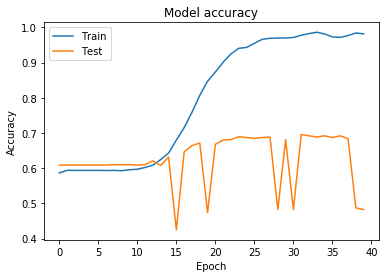

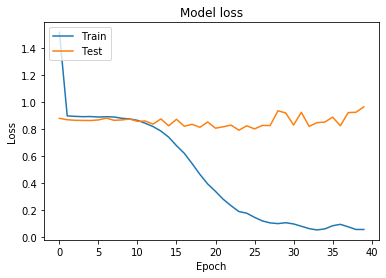

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

evaluate the best model

In [30]:
model = create_model()
model.evaluate(test_dataset)
model.load_weights('model_1_A/')
score = model.evaluate(test_dataset)

9/9 [==============================] - 4s 491ms/step - loss: 0.9248 - acc: 0.6955 - f1: 0.7016 - recall: 0.7016


classification report

In [31]:
from sklearn.metrics import classification_report

labels = []
score = model.predict(test_dataset)

for _ , label in test_dataset :
  for i in label :
    labels.append(i.numpy())
target_names = ['Positive','Negative','Neutral']

print(classification_report(labels, score > 0.5, target_names=target_names))

              precision    recall  f1-score   support

    Positive       0.68      0.97      0.80       506
    Negative       0.88      0.21      0.34        67
     Neutral       0.80      0.29      0.42       258

   micro avg       0.70      0.70      0.70       831
   macro avg       0.78      0.49      0.52       831
weighted avg       0.73      0.70      0.64       831
 samples avg       0.70      0.70      0.70       831



In [32]:
!zip -r model_A.zip 'model_1_A'

  adding: model_1_A/ (stored 0%)
  adding: model_1_A/.data-00001-of-00002 (deflated 7%)
  adding: model_1_A/checkpoint (deflated 34%)
  adding: model_1_A/.index (deflated 72%)
  adding: model_1_A/.data-00000-of-00002 (deflated 27%)
